In [0]:
import numpy as np
import pandas as pd 

In [0]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [0]:
df = pd.read_csv("/content/diabetes.csv")

In [48]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
!pip uninstall pandas-profiling

Uninstalling pandas-profiling-1.4.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/pandas_profiling-1.4.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/pandas_profiling/*
Proceed (y/n)? y
  Successfully uninstalled pandas-profiling-1.4.1


In [9]:
!pip install pandas-profiling

     |████████████████████████████████| 266kB 2.8MB/s 
     |████████████████████████████████| 604kB 48.7MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 3.1MB 43.0MB/s 
     |████████████████████████████████| 296kB 49.3MB/s 
  Created wheel for confuse: filename=confuse-1.1.0-cp36-none-any.whl size=17574 sha256=59749e732c56077544b04ff67b4becbc0a9ff086b4d6d968fabac986ce7378b3
  Stored in directory: /root/.cache/pip/wheels/f6/8b/23/41a1b516f6d8d4cc81f5bdb55394a47cdbe9659c53668d3c9e
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=4be017477c76d8fe607551b567b3470d9e67b0aec768a5a700716733afaabfc7
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for imagehash: filename=ImageHash-4.1.0-py2.py3-none-any.whl size=291990 sha256=0aae11256c11e51833861402b4dffbd4b8576c70124cadf21ba4

In [0]:
from pandas_profiling import ProfileReport

In [50]:
prof=ProfileReport(df)
prof.to_file(output_file='/content/output.html')
prof

In [51]:
prof=ProfileReport(df,minimal=True)
prof.to_file(output_file='/content/output-min.html')
prof

In [0]:
X = df.drop("Outcome", axis=1)
y = df['Outcome']

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [54]:
sum(y_train), len(y_train)

(217, 614)

In [0]:
from sklearn.preprocessing import MinMaxScaler
X_train
y_train
sc = MinMaxScaler((-1, 1))

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [56]:
X_test
len(X_train)

614

In [0]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn, optim

In [0]:
class Dataset(Dataset):
   
   
    def __init__(self, x, y):
    
        self.len = len(x)

        self.x=torch.tensor(x).float()
        self.y=torch.tensor(y.values).long()

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

In [0]:
trainDataset=Dataset(X_train, y_train)

In [60]:
trainDataset[0]

(tensor([-0.4667,  0.4774,  0.2131, -0.4949, -0.3073,  0.0402, -0.7378, -0.7000]),
 tensor(0))

In [0]:
trainLoader=DataLoader(dataset=trainDataset,
                        batch_size=64,
                        shuffle=True,
                        num_workers=64)

In [0]:
validationDataset=Dataset(X_test, y_test)

In [0]:
validationLoader=DataLoader(dataset=validationDataset,
                        batch_size=32,
                        shuffle=True,
                        num_workers=1)

In [0]:
class HeartDiseaseNN(nn.Module):
    def __init__(self):
        super(HeartDiseaseNN, self).__init__()

     
        self.sequential= nn.Sequential(
            nn.Linear(8,100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Linear(60, 2)
        )


    def forward(self, x):
        return self.sequential(x)

In [0]:
net = HeartDiseaseNN()

In [0]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [0]:
train_losses = []

In [0]:
accuracies=[]

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
def train(epoch):
   
    net.train()
    losses=[]
    for batch_idx, data in enumerate(trainLoader, 0):
      inputs, labels =data
    
      outputs = net(inputs)
  
      loss = criterion(outputs, labels)

      losses.append(loss.item())
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      print(f"[Train Epoch: {epoch}, Batch: {batch_idx+1}, Loss: {loss.item()}")
    mean_loss=sum(losses)/len(losses)
    scheduler.step(mean_loss)
    train_losses.append(mean_loss)
    print(f"[TRAIN] Epoch: {epoch} Loss:{mean_loss}")

In [0]:
test_losses=[]

In [0]:
def validation():
  
    net.eval()

    test_loss=[]
    correct = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(validationLoader, 0):
          inputs, labels = data

          output=net(inputs)

          loss= criterion(output, labels)
          test_loss.append(loss.item())

       
          pred = output.data.max(1, keepdim=True)[1]

       
          correct += pred.eq(labels.data.view_as(pred)).sum()
          current_correct=pred.eq(labels.data.view_as(pred)).sum()          
          print("============")
          print(f"[Validation set] Batch index: {batch_idx+1} Batch loss: {loss.item()}, Accuracy: {100. * current_correct/len(inputs)}%")
          print("============")
        mean_loss=sum(test_loss)/len(test_loss)
        test_losses.append(mean_loss)
        accuracy = 100. * correct/len(validationLoader.dataset)
        print(f"[Validation set] Loss: {mean_loss}, Accuracy: {accuracy}%")
          
        accuracies.append(accuracy)

In [73]:
for epoch in range(100):
  train(epoch)
  validation()

[Train Epoch: 0, Batch: 1, Loss: 0.6977742910385132
[Train Epoch: 0, Batch: 2, Loss: 0.694265604019165
[Train Epoch: 0, Batch: 3, Loss: 0.7013742923736572
[Train Epoch: 0, Batch: 4, Loss: 0.6971923112869263
[Train Epoch: 0, Batch: 5, Loss: 0.6919959783554077
[Train Epoch: 0, Batch: 6, Loss: 0.6851880550384521
[Train Epoch: 0, Batch: 7, Loss: 0.6847626566886902
[Train Epoch: 0, Batch: 8, Loss: 0.6857997179031372
[Train Epoch: 0, Batch: 9, Loss: 0.6815913915634155
[Train Epoch: 0, Batch: 10, Loss: 0.7042773365974426
[TRAIN] Epoch: 0 Loss:0.6924221634864807
[Validation set] Batch index: 1 Batch loss: 0.6839674711227417, Accuracy: 68.75%
[Validation set] Batch index: 2 Batch loss: 0.6914729475975037, Accuracy: 62.5%
[Validation set] Batch index: 3 Batch loss: 0.6751418709754944, Accuracy: 71.875%
[Validation set] Batch index: 4 Batch loss: 0.6836283206939697, Accuracy: 65.625%
[Validation set] Batch index: 5 Batch loss: 0.6831888556480408, Accuracy: 65.38461303710938%
[Validation set] Loss

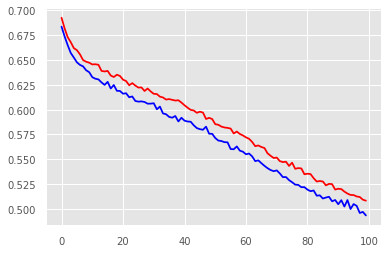

In [74]:
plt.plot(train_losses, "r-", test_losses, "b-")

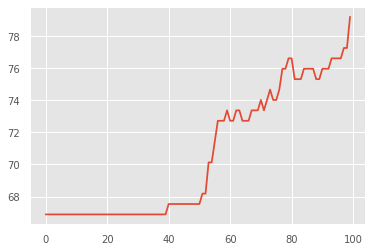

In [75]:
plt.plot(accuracies)

In [0]:
def try_a_single_example_with_the_network(index_from_the_validation_set):
  with torch.no_grad():
    pred_test = net(validationDataset[index_from_the_validation_set][0].view(1, -1))
    _, preds_y = torch.max(pred_test, 1)
    return preds_y

In [0]:
index_of_test=30

In [78]:
print(f"Neural network response is: {try_a_single_example_with_the_network(index_of_test).item()}")
print(f"Actual response is: {validationDataset[index_of_test][1].view(-1).item()}")

Neural network response is: 0
Actual response is: 0
